Code adapted from Deep Reinforcement Learning in Action

# Imports

In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Utility function to calculate running mean

In [2]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

# Environment

In [3]:
env = gym.make("CartPole-v0")

# Policy Network

In [4]:
l1 = 4 # Number of input nodes
l2 = 150 # Number of hidden layer nodes
l3 = 2 # Number of output layer nodes

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0) # Output is softmax probability distribution over actions
)

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
state1 = env.reset() # Returns start state
pred = model(torch.from_numpy(state1).float()) # Call policy network model to produce predicted action probabilities
action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) # Sample an action from the probability distribution produced by the policy network
state2, reward, done, info = env.step(action) # Take the action, receive new state and reward. The info variable is irrelevant here

Utility function to discount and normalize rewards

In [6]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards # Compute exponentially decaying rewards
    disc_return /= disc_return.max() # Normalize the rewards to be within the [0,1] interval to improve numerical stability
    return disc_return

Loss function

In [7]:
def loss_fn(preds, r): # Expects an array of action probabilities for the actions that were taken and the discounted rewards.
    return -1 * torch.sum(r * torch.log(preds)) # Computes log of the probabilities, multiplies by the discounted rewards, sums them all and flips the sign.

Hyperparameters and initialization

In [8]:
MAX_DUR = 200
MAX_EPISODES = 500
gamma = 0.99
score = [] # List to keep track of the episode length over training time

# Training

In [9]:
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] # List for storing transitions: state, action, rewards

    for t in range(MAX_DUR): # While in episode
        act_prob = model(torch.from_numpy(curr_state).float()) # Get the action probabilities
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) # Select an action stochastically
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) # Take the action in the environment
        transitions.append((prev_state, action, t+1)) # Store this transition
        if done: # Truncated or terminated
            break

    ep_len = len(transitions)
    score.append(ep_len) # Score is equal to episode length
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) # Collect all the rewards in the episode in a single tensor
    disc_returns = discount_rewards(reward_batch) # Compute the discounted version of the rewards
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) # Collect the states in the episode in a single tensor
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) # Collect the actions in the episode in a single tensor
    pred_batch = model(state_batch) # Recompute the action probabilities for all the states in the episode
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() # Subset the action-probabilities associated with the actions that were actually taken
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad() # Clear any resident gradients
    loss.backward() # Calculate gradients
    optimizer.step() # Make updates

In [10]:
score = np.array(score)
avg_score = running_mean(score, 50)

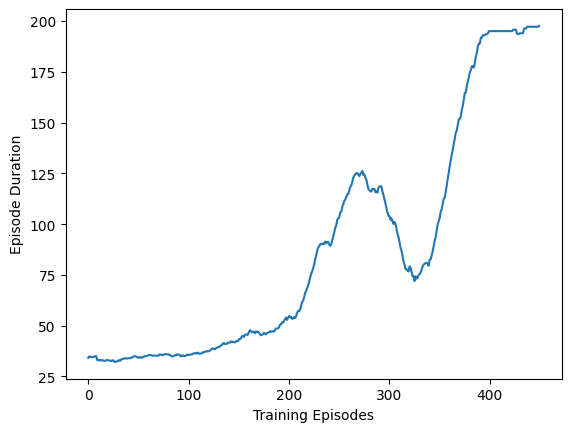

In [11]:
plt.figure()
plt.ylabel("Episode Duration")
plt.xlabel("Training Episodes")
plt.plot(avg_score)

# Evaluation

In [12]:
score = []
games = 100
done = False
state1 = env.reset()
for i in range(games):
    t=0
    while not done: #F
        pred = model(torch.from_numpy(state1).float())
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
        state2, reward, done, info = env.step(action)
        state1 = state2
        t += 1
        if t > MAX_DUR:
            break;
    state1 = env.reset()
    done = False
    score.append(t)

In [13]:
score = np.array(score)

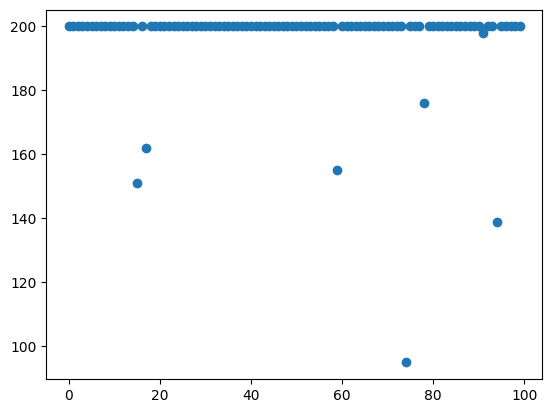

In [14]:
plt.scatter(np.arange(score.shape[0]),score)

# Further experiments

1. Different hyperparameters


*   NN architecture
*   Learning rate α
*   Number of episodes
*   Max length of episodes
*   Discount factor γ


2. Different environments